In [2]:
# connect aspen plus to python

import win32com.client as win32
aspen = win32.Dispatch('Apwn.Document.37.0')
aspen.InitFromFile(r'C:\Users\USER\Desktop\Project\Aspen practice\validation.apwz')
aspen.Run2()
aspen.Visible = 1

In [3]:
# install important libraries

import pandas as pd
import numpy as np
import random
import csv
import os

In [4]:
# function to populate csv file with generated data

header = ['decomp_temp', 'pyrol_temp', 'gasifier_temp', 'air_to_biomass_ratio', 'gasifier_length', 'gasifier_diameter', \
                     'fuel_cell_temp', 'Acell', 'fuel_utilization_factor', 'depleted_fuel_frac',\
          'Power', 'CO2_emitted', 'H2_produced', 'current_density', 'cell_current']
def write_to_csv(filename, data):
    file_exists = os.path.isfile(filename)
    with open(filename, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        if not file_exists:
            writer.writerow(header)
        for i in data:
            writer.writerow(i)

In [5]:
def run_model(decomp_temp, pyrol_temp, gasifier_temp, air_to_biomass_ratio, gasifier_length, gasifier_diameter,\
              fuel_cell_temp, Acell, fuel_utilization_factor, depleted_fuel_frac, fuel_cell_temp_in_K):
    
#     specify parameters
    mass_of_biomass = 5000
    mole_of_biomass = mass_of_biomass / 33.54032
    air_into_gasifier = air_to_biomass_ratio * mole_of_biomass
    
    moles_of_H2_in = aspen.Tree.FindNode(r"\Data\Streams\H2-RICH\Output\MOLEFLOW\MIXED\H2").Value
    moles_of_O2_into_anode = 0.5*fuel_utilization_factor*moles_of_H2_in
    O2_into_fuel_cell = 4 * moles_of_O2_into_anode
    air_into_fuel_cell = O2_into_fuel_cell / 0.21
    total_air_in = air_into_gasifier + air_into_fuel_cell
    
    split_frac = air_into_gasifier / total_air_in
    
    F = 96485
    R = 8.314
#     E0 = (4187 * (58.3 - (0.0113 + 9.6 * 10**(-7)*fuel_cell_temp)*fuel_cell_temp)) / (2*F)
    E0 = 1.2728 -(2.76 * 10**(-4)*fuel_cell_temp_in_K)
    P_fuel = aspen.Tree.FindNode(r"\Data\Blocks\ANODE\Input\PRES").Value * 101325
    H2_mole_frac = aspen.Tree.FindNode(r"\Data\Streams\H2-RICH\Output\MOLEFRAC\MIXED\H2").Value
    H2O_frac = aspen.Tree.FindNode(r"\Data\Streams\S5\Output\MOLEFRAC\MIXED\WATER").Value
    Cell_Pressure = aspen.Tree.FindNode(r"\Data\Blocks\ANODE\Input\PRES").Value * 101325
    
    P_reactant = P_fuel**1.5 * H2_mole_frac * 0.21**0.5
    P_product = H2O_frac * Cell_Pressure
#     Vn = E0 + (R*fuel_cell_temp_in_K*np.log(P_reactant/P_product)/(2*F))
    
#     P_reactant = P_fuel**1.5 * H2_mole_frac * 0.21**0.5
#     P_product = H2O_frac * Cell_Pressure
    Vn = E0 + (R*fuel_cell_temp_in_K*np.log(P_reactant/P_product)/(2*F))
    
    j_star_O2 = 7 * 10**9
    j_star_H2 = 7 * 10**9
    no_of_cells = 1500
    Eanode = 110000
    Ecathode = 120000
    tanode = 100 * 10**(-6)
    tcathode = 2.2 * 10**(-3)
    telectrolyte = 40 * 10**(-6)
    tinterconnect = 85 * 10**(-6)
    transfer_coefficient = 0.5
    cell_current = 4 * F * moles_of_O2_into_anode * 1000 / (3600 * no_of_cells)
    current_density = cell_current / Acell
    porosity = 0.5
    tortuosity = 3 
    
    
#     Gasification2
    aspen.Tree.FindNode(r"\Data\Streams\BIOMASS\Input\TEMP\NC").SetValueAndUnit(decomp_temp, 4)
    aspen.Tree.FindNode(r"\Data\Blocks\DECOMP\Input\TEMP").SetValueAndUnit(decomp_temp, 4)
    aspen.Tree.FindNode(r"\Data\Blocks\PYRO\Input\TEMP").SetValueAndUnit(pyrol_temp, 4)
    aspen.Tree.FindNode(r"\Data\Blocks\GASIFIER\Input\REAC_TEMP").SetValueAndUnit(gasifier_temp, 4)
    aspen.Tree.FindNode(r"\Data\Blocks\AIR-SPLI\Input\FRAC\HT-AIR-G").SetValueAndUnit(split_frac, 0)
    aspen.Tree.FindNode(r"\Data\Streams\AIR\Input\TOTFLOW\MIXED").SetValueUnitAndBasis(total_air_in, 3, 'MOLE')
    aspen.Tree.FindNode(r"\Data\Blocks\GASIFIER\Input\LENGTH").SetValueAndUnit(gasifier_length, 3)
    aspen.Tree.FindNode(r"\Data\Blocks\GASIFIER\Input\DIAM").SetValueAndUnit(gasifier_diameter, 3)
    
    
#    Fuel Cell
    aspen.Tree.FindNode(r"\Data\Streams\AIR\Input\TOTFLOW\MIXED").SetValueUnitAndBasis(total_air_in, 3, 'MOLE')
    aspen.Tree.FindNode(r"\Data\Blocks\AIR-SPLI\Input\FRAC\HT-AIR-G").SetValueAndUnit(split_frac, 0)
    aspen.Tree.FindNode(r"\Data\Blocks\ANODE\Input\TEMP").SetValueAndUnit(fuel_cell_temp, 4)
    aspen.Tree.FindNode(r"\Data\Blocks\ANODE\Input\CONV\1").SetValueAndUnit(fuel_utilization_factor, 0)
    aspen.Tree.FindNode(r"\Data\Blocks\CELLEXSP\Input\FRAC\DEP-FUEL").SetValueAndUnit(depleted_fuel_frac, 0)
    aspen.Tree.FindNode(r"\Data\Blocks\FEED-PH\Input\TEMP").SetValueAndUnit(fuel_cell_temp, 4)
    aspen.Tree.FindNode(r"\Data\Blocks\PREREFMR\Input\TEMP").SetValueAndUnit(fuel_cell_temp, 4)
    aspen.Tree.FindNode(r"\Data\Blocks\AIR-PH\Input\TEMP").SetValueAndUnit(fuel_cell_temp, 4)
        
    aspen.Run2()
    
    H2_produced = aspen.Tree.FindNode(r"\Data\Streams\RAW-GAS\Output\MASSFLOW\MIXED\H2").Value 
    CO2_emitted = aspen.Tree.FindNode(r"\Data\Streams\EXHAUST\Output\MASSFLOW\MIXED\CO2").Value
    
    
#     ohmic voltage loss
    
    res_cathode = (8.11*10**-5) * np.exp(600 / fuel_cell_temp_in_K)
    res_electrolyte = (2.94*10**-5) * np.exp(10350 / fuel_cell_temp_in_K)
    res_anode = (2.98*10**-5) * np.exp(-1392 / fuel_cell_temp_in_K)
    res_interconnect = 0.025
    
    Vohm = (current_density)*((telectrolyte * res_electrolyte) + (tcathode * res_cathode) + \
                              (tanode * res_electrolyte) + (tinterconnect * res_interconnect))
    
    
#     activation voltage loss
    
    joanode = j_star_H2 * Acell * (H2_mole_frac) * (H2O_frac) * np.exp(-Eanode / (R * fuel_cell_temp_in_K))
    jocathode = j_star_O2 * Acell * (0.21)**0.25 * np.exp(-Ecathode / (R * fuel_cell_temp_in_K))
    
    Vact = ((R * fuel_cell_temp_in_K/(2*0.5*F))*np.log(current_density/joanode)) + \
                    ((R * fuel_cell_temp_in_K/(4*0.5*F))*np.log(current_density/jocathode))
    
#     concentration voltage loss
    
    DeffH2_H2O = (porosity/tortuosity)*(4.1679*10**-5 * fuel_cell_temp_in_K**1.75 / P_fuel)
    DeffO2_N2 = (porosity/tortuosity)*(9.80153*10**-6 * fuel_cell_temp_in_K**1.75 / P_fuel)
    Jlimanode = -(2 * F * DeffH2_H2O * H2_mole_frac * P_fuel) / (R * fuel_cell_temp_in_K * tanode)
    Jlimcathode = -(4 * F * DeffO2_N2 * 0.21 * P_fuel) / (R * fuel_cell_temp_in_K * tcathode)
    Vconcanode = R*fuel_cell_temp_in_K*np.log(1 -(current_density / Jlimanode))/(2*F)
    Vconccathode = R*fuel_cell_temp_in_K*np.log(1 -(current_density / Jlimcathode))/(2*F)
    Vconc = Vconcanode + Vconccathode
    
    Ecell = Vn - Vohm - Vact - Vconc
    
    Power = Ecell * cell_current
    
    return [Power, CO2_emitted, H2_produced, current_density, cell_current]

In [ ]:
no_of_iterations = 5000
data = []
for i in range(no_of_iterations):
    
#     generate random input parameters
    decomp_temp = round(random.uniform(400, 600), 0)
    pyrol_temp = round(random.uniform(600, 700), 0)
    gasifier_temp = round(random.uniform(700, 900), 0)
    air_to_biomass_ratio = round(random.uniform(0.6, 1), 2)
    gasifier_length = round(random.uniform(1, 3), 2)
    gasifier_diameter = round(random.uniform(0.5, 2), 2)
    fuel_cell_temp_in_K = round(random.uniform(1123, 1273), 2)
    fuel_cell_temp = fuel_cell_temp_in_K - 273
    Acell = round(random.uniform(0.25, 0.4), 5)
    fuel_utilization_factor = round(random.uniform(0.5, 1), 2)
    depleted_fuel_frac = round(random.uniform(0.1, 0.4), 2)

    
    [Power, CO2_emitted, H2_produced, current_density, cell_current] = run_model(decomp_temp, pyrol_temp, gasifier_temp, \
                                                                                 air_to_biomass_ratio, gasifier_length, \
                                                                                 gasifier_diameter, fuel_cell_temp, \
                                                                                 Acell, fuel_utilization_factor, \
                                                                                 depleted_fuel_frac, fuel_cell_temp_in_K)
# check for error in simulation
    lst = []
    i = 1
    path = rf'\Data\Results Summary\Run-Status\Output\PER_ERROR\{i}'
    while str(aspen.Tree.FindNode(path)) != 'None':
        path = rf'\Data\Results Summary\Run-Status\Output\PER_ERROR\{i}'
        result = str(aspen.Tree.FindNode(path))
        result_list = result.split()
        for word in result_list:
            lst.append(word)
        i += 1
    if 'errors:' not in lst:
        data.append([decomp_temp, pyrol_temp, gasifier_temp,  air_to_biomass_ratio, gasifier_length, gasifier_diameter, \
                     fuel_cell_temp, Acell, fuel_utilization_factor, depleted_fuel_frac, \
                     Power, CO2_emitted, H2_produced, current_density, cell_current])

In [ ]:
# save file
filename = 'IGFC_new.csv'

write_to_csv(filename, data)
        
print(len(data))

In [6]:
# testing...

no_of_iterations = 50
variable = []
power = []
co2 = []
for i in range(no_of_iterations):

    decomp_temp = 459
    pyrol_temp = 625
    gasifier_temp = 714.8
    air_to_biomass_ratio = 0.74
    gasifier_length = 1.05
    gasifier_diameter = 0.51
    fuel_cell_temp_in_K = 900
    fuel_cell_temp = fuel_cell_temp_in_K - 273
    Acell = 0.39916
    fuel_utilization_factor = round(random.uniform(0.5, 1), 2)
    depleted_fuel_frac = 0.3
    
    [Power, CO2_emitted, H2_produced, current_density, cell_current] = run_model(decomp_temp, pyrol_temp, gasifier_temp, \
                                                                                 air_to_biomass_ratio, gasifier_length, \
                                                                                 gasifier_diameter, fuel_cell_temp, \
                                                                                 Acell, fuel_utilization_factor, \
                                                                                 depleted_fuel_frac, fuel_cell_temp_in_K)


    lst = []
    i = 1
    path = rf'\Data\Results Summary\Run-Status\Output\PER_ERROR\{i}'
    while str(aspen.Tree.FindNode(path)) != 'None':
        path = rf'\Data\Results Summary\Run-Status\Output\PER_ERROR\{i}'
        result = str(aspen.Tree.FindNode(path))
        result_list = result.split()
        for word in result_list:
            lst.append(word)
        i += 1
    if 'errors:' not in lst:
        variable.append(fuel_utilization_factor)
        power.append(Power)
        co2.append(CO2_emitted)

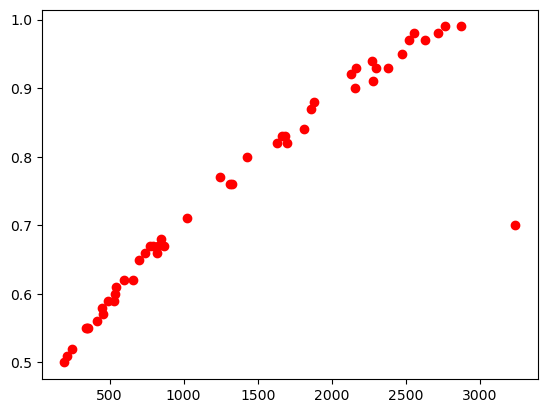

In [7]:
import matplotlib.pyplot as plt
plt.scatter(power, variable, color='red', marker = 'o')